# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Mentoría 16 - ¿Cómo identificar fuga de ventas? Inteligencia artificial aplicada al sector comercial.

### Explorando Patrones de Datos a través de Clustering (TP3)

**Integrantes:**
- Canalis, Patricio.
- Chevallier-Boutell, Ignacio José.
- Villarroel Torrez, Daniel.

**Mentores:**
- Gonzalez, Lucía
- Lahoz, Nahuel

---
## Librerías

In [1]:
# Para que las funciones se actualicen sin tener que refrescar el kernel
%load_ext autoreload
%autoreload 2

# Funciones de visualización y curación
import pandas as pd
import json
from os.path import exists
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress as LR
from scipy.stats import skew, kurtosis, skewtest, kurtosistest

# Funciones de clustering
from sklearn.cluster import KMeans, MeanShift
from sklearn import manifold, preprocessing, decomposition

# Funciones propias
from utils_limpieza import * 

# Clear preferencias
plt.rcdefaults()
pd.reset_option('^display\.float_format')

---
## Preparación de Datos <span style="color:magenta">**(Paso 1)**</span>

Se sintetizan todos los pasos de curación, a fin de tener a mano en caso de tener que revisar alguno de ellos. (Por hacer)

In [3]:
vectores = pd.read_csv('../data/interim/tp2_vendedores_vector_resumen.csv')
vectores.head()

,ID,Subrubro,Omega,Modelo,F_pct_Com_1905,F_pct_Com_1906,F_pct_Com_1907,F_pct_Com_1908,F_pct_Com_1909,F_pct_Com_1910,...,Y_pct_Ven_2205,Y_pct_Ven_2206,F_ven_mean,F_ven_var,F_com_mean,F_com_var,Y_ven_mean,Y_ven_var,Y_com_mean,Y_com_var
0,0,Miscelaneo,1,0,0.580417,-0.388794,-0.965554,-0.987604,-0.987604,-0.943642,...,-0.119376,-0.352698,4055.855791,1.476730e+08,3787.351470,1.287680e+08,7470.411113,1.945619e+08,6987.879840,1.756728e+08
1,1,Miscelaneo,1,0,0.559349,0.591999,0.011470,-0.267213,-0.441588,-0.430018,...,0.475884,0.351416,35.874023,4.953037e+04,35.851674,4.953200e+04,69.548969,1.489747e+05,71.819984,1.539465e+05
2,2,Miscelaneo,1,0,0.012719,-0.010125,0.325712,0.167671,-0.260562,0.173718,...,-0.221058,-0.274480,1.670852,8.508866e+01,1.667198,8.509434e+01,2.757303,1.654879e+02,2.732026,1.713125e+02
3,4,Gondola,1,0,0.193896,0.072714,-0.055670,0.027243,-0.173982,0.008415,...,-0.396566,-0.151606,0.028906,4.450034e-02,0.010101,4.674346e-02,0.106075,1.108827e-01,0.039290,1.070464e-01
4,5,Com. Varios,1,0,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.188794,-0.188794,4.737902,1.428076e+02,4.700975,1.430781e+02,2.945724,1.647887e+01,2.466424,1.172261e+01


In [14]:
# Definir grupos de variables:

F_Com = ['F_pct_Com_1905', 'F_pct_Com_1906', 'F_pct_Com_1907', 'F_pct_Com_1908', 
         'F_pct_Com_1909', 'F_pct_Com_1910', 'F_pct_Com_1911', 'F_pct_Com_1912',
         'F_pct_Com_2001', 'F_pct_Com_2002', 'F_pct_Com_2003', 'F_pct_Com_2004',
         'F_pct_Com_2005', 'F_pct_Com_2006', 'F_pct_Com_2007', 'F_pct_Com_2008',
         'F_pct_Com_2009', 'F_pct_Com_2010', 'F_pct_Com_2011', 'F_pct_Com_2012',
         'F_pct_Com_2101', 'F_pct_Com_2102', 'F_pct_Com_2103', 'F_pct_Com_2104',
         'F_pct_Com_2105', 'F_pct_Com_2106', 'F_pct_Com_2107', 'F_pct_Com_2108',
         'F_pct_Com_2109', 'F_pct_Com_2110', 'F_pct_Com_2111', 'F_pct_Com_2112',
         'F_pct_Com_2201', 'F_pct_Com_2202', 'F_pct_Com_2203', 'F_pct_Com_2204',
         'F_pct_Com_2205', 'F_pct_Com_2206']

F_Ven = ['F_pct_Ven_1905', 'F_pct_Ven_1906', 'F_pct_Ven_1907', 'F_pct_Ven_1908', 
         'F_pct_Ven_1909', 'F_pct_Ven_1910', 'F_pct_Ven_1911', 'F_pct_Ven_1912',
         'F_pct_Ven_2001', 'F_pct_Ven_2002', 'F_pct_Ven_2003', 'F_pct_Ven_2004',
         'F_pct_Ven_2005', 'F_pct_Ven_2006', 'F_pct_Ven_2007', 'F_pct_Ven_2008',
         'F_pct_Ven_2009', 'F_pct_Ven_2010', 'F_pct_Ven_2011', 'F_pct_Ven_2012',
         'F_pct_Ven_2101', 'F_pct_Ven_2102', 'F_pct_Ven_2103', 'F_pct_Ven_2104',
         'F_pct_Ven_2105', 'F_pct_Ven_2106', 'F_pct_Ven_2107', 'F_pct_Ven_2108',
         'F_pct_Ven_2109', 'F_pct_Ven_2110', 'F_pct_Ven_2111', 'F_pct_Ven_2112',
         'F_pct_Ven_2201', 'F_pct_Ven_2202', 'F_pct_Ven_2203', 'F_pct_Ven_2204',
         'F_pct_Ven_2205', 'F_pct_Ven_2206']

Y_Com = ['Y_pct_Com_2001', 'Y_pct_Com_2002', 'Y_pct_Com_2003', 'Y_pct_Com_2004',
         'Y_pct_Com_2005', 'Y_pct_Com_2006', 'Y_pct_Com_2007', 'Y_pct_Com_2008',
         'Y_pct_Com_2009', 'Y_pct_Com_2010', 'Y_pct_Com_2011', 'Y_pct_Com_2012',
         'Y_pct_Com_2101', 'Y_pct_Com_2102', 'Y_pct_Com_2103', 'Y_pct_Com_2104',
         'Y_pct_Com_2105', 'Y_pct_Com_2106', 'Y_pct_Com_2107', 'Y_pct_Com_2108',
         'Y_pct_Com_2109', 'Y_pct_Com_2110', 'Y_pct_Com_2111', 'Y_pct_Com_2112',
         'Y_pct_Com_2201', 'Y_pct_Com_2202', 'Y_pct_Com_2203', 'Y_pct_Com_2204',
         'Y_pct_Com_2205', 'Y_pct_Com_2206']

Y_Ven = ['Y_pct_Ven_2001', 'Y_pct_Ven_2002', 'Y_pct_Ven_2003', 'Y_pct_Ven_2004',
         'Y_pct_Ven_2005', 'Y_pct_Ven_2006', 'Y_pct_Ven_2007', 'Y_pct_Ven_2008',
         'Y_pct_Ven_2009', 'Y_pct_Ven_2010', 'Y_pct_Ven_2011', 'Y_pct_Ven_2012',
         'Y_pct_Ven_2101', 'Y_pct_Ven_2102', 'Y_pct_Ven_2103', 'Y_pct_Ven_2104',
         'Y_pct_Ven_2105', 'Y_pct_Ven_2106', 'Y_pct_Ven_2107', 'Y_pct_Ven_2108',
         'Y_pct_Ven_2109', 'Y_pct_Ven_2110', 'Y_pct_Ven_2111', 'Y_pct_Ven_2112',
         'Y_pct_Ven_2201', 'Y_pct_Ven_2202', 'Y_pct_Ven_2203', 'Y_pct_Ven_2204',
         'Y_pct_Ven_2205', 'Y_pct_Ven_2206']

basics = ['Modelo', 'Subrubro']

In [37]:
#vectores_interes = vectores[basics + Y_Ven]
vectores_interes = vectores[Y_Ven]
vectores_interes.head()

,Y_pct_Ven_2001,Y_pct_Ven_2002,Y_pct_Ven_2003,Y_pct_Ven_2004,Y_pct_Ven_2005,Y_pct_Ven_2006,Y_pct_Ven_2007,Y_pct_Ven_2008,Y_pct_Ven_2009,Y_pct_Ven_2010,Y_pct_Ven_2011,Y_pct_Ven_2012,Y_pct_Ven_2101,Y_pct_Ven_2102,Y_pct_Ven_2103,Y_pct_Ven_2104,Y_pct_Ven_2105,Y_pct_Ven_2106,Y_pct_Ven_2107,Y_pct_Ven_2108,Y_pct_Ven_2109,Y_pct_Ven_2110,Y_pct_Ven_2111,Y_pct_Ven_2112,Y_pct_Ven_2201,Y_pct_Ven_2202,Y_pct_Ven_2203,Y_pct_Ven_2204,Y_pct_Ven_2205,Y_pct_Ven_2206
0,-0.980420,-0.965571,-0.965571,-0.987611,-0.987611,-0.943671,36606.764001,37024.978792,37024.978792,37024.978792,29167.514747,10732.811495,10732.811495,2266.832776,2266.832776,2266.832776,2266.832776,2266.832776,-0.938050,-0.938750,-0.997244,-0.997244,-0.919475,-0.450937,-0.819822,-0.147205,0.023844,-0.119376,-0.119376,-0.352698
1,0.032923,0.067118,-0.569663,-0.999617,-0.929885,-0.322981,-0.201898,-0.273524,-0.348675,-0.448290,-0.398790,-0.216869,-0.358698,-0.373762,0.747936,2149.215226,7.797906,-0.072916,-0.195142,0.134928,0.353202,0.299397,0.244381,-0.052702,-0.021221,0.453017,0.027594,0.183219,0.475884,0.351416
2,0.256607,0.174306,-0.298710,-0.971207,-0.548703,-0.125982,0.097048,0.442733,2.131407,2.082447,1.524440,0.615983,0.300691,-0.034593,2.914301,71.848516,2.098552,1.304784,0.223360,0.211571,-0.250917,-0.102872,-0.431158,-0.332711,-0.332390,0.737398,-0.645376,-0.433219,-0.221058,-0.274480
3,-0.090954,-0.366634,-0.118110,-0.068514,-0.156388,-0.206558,-0.085699,-0.127638,0.153705,0.146317,0.285224,0.371626,0.344026,1.025021,0.349786,0.401290,0.238506,0.229865,0.431187,0.427207,0.168828,-0.037599,-0.102040,-0.167593,-0.381054,-0.416867,-0.242169,-0.277885,-0.396566,-0.151606
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.089056,4.501752,4.501752,12.040616,2.792752,6.219453,0.191694,0.191694,0.191694,2.515726,-0.676641,1.093143,3.899372,-0.188794,-0.188794


Hay problemas con los vacíos, para que me los tome el modelo:

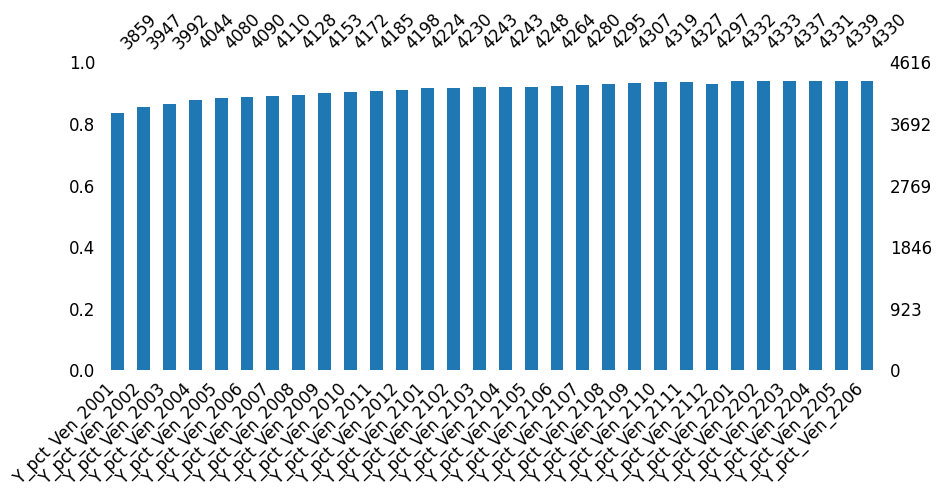

In [38]:
msno.bar(vectores_interes, fontsize=12, color="tab:blue", figsize=(10, 4))
plt.show()

In [39]:
# Paso 1: Contar valores vacíos por fila
vacios_por_fila = vectores_interes.isnull().sum(axis=1)

# Paso 2: Generar un resumen de cuántas filas tienen 0, 1, 2, 3, etc., valores vacíos
resumen = vacios_por_fila.value_counts().reset_index()
resumen.columns = ['Cantidad de Valores Vacíos', 'Número de Filas']
resumen = resumen.sort_values(by='Cantidad de Valores Vacíos')
resumen.head()

,Cantidad de Valores Vacíos,Número de Filas
0,0,3630
1,1,169
4,2,56
3,3,60
5,4,50


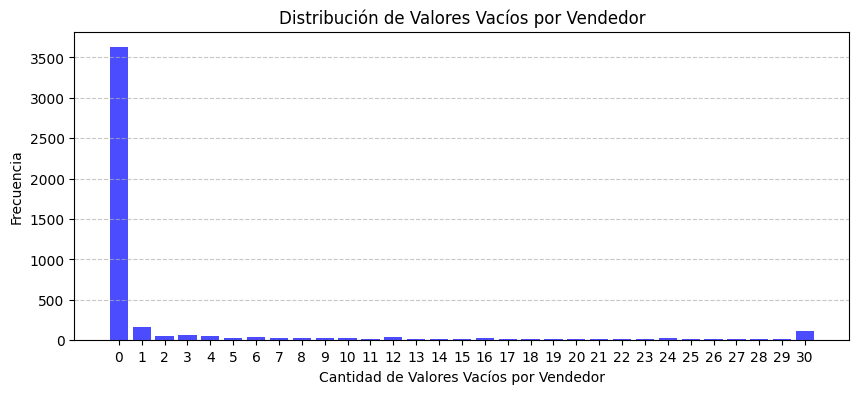

In [40]:
plt.figure(figsize=(10, 4))  # Tamaño del gráfico
plt.bar(resumen['Cantidad de Valores Vacíos'], resumen['Número de Filas'], color='blue', alpha=0.7)
plt.xlabel('Cantidad de Valores Vacíos por Vendedor')
plt.ylabel('Frecuencia')
plt.title('Distribución de Valores Vacíos por Vendedor')
plt.xticks(resumen['Cantidad de Valores Vacíos'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Muestra el gráfico
plt.show()


También hay problema de outliers. Qué significa que una variación me dé -20.000%. Que tenía ej 1.000.000 y pasé a 0,05?. Algo hay que hacer

In [46]:
vectores_interes.describe()

,Y_pct_Ven_2001,Y_pct_Ven_2002,Y_pct_Ven_2003,Y_pct_Ven_2004,Y_pct_Ven_2005,Y_pct_Ven_2006,Y_pct_Ven_2007,Y_pct_Ven_2008,Y_pct_Ven_2009,Y_pct_Ven_2010,Y_pct_Ven_2011,Y_pct_Ven_2012,Y_pct_Ven_2101,Y_pct_Ven_2102,Y_pct_Ven_2103,Y_pct_Ven_2104,Y_pct_Ven_2105,Y_pct_Ven_2106,Y_pct_Ven_2107,Y_pct_Ven_2108,Y_pct_Ven_2109,Y_pct_Ven_2110,Y_pct_Ven_2111,Y_pct_Ven_2112,Y_pct_Ven_2201,Y_pct_Ven_2202,Y_pct_Ven_2203,Y_pct_Ven_2204,Y_pct_Ven_2205,Y_pct_Ven_2206
count,3859.000000,3947.000000,3992.000000,4044.000000,4080.000000,4090.000000,4110.000000,4128.000000,4153.000000,4172.000000,4185.000000,4198.000000,4224.000000,4230.000000,4243.000000,4243.000000,4248.000000,4264.000000,4280.000000,4295.000000,4.307000e+03,4319.000000,4327.000000,4297.000000,4332.000000,4333.000000,4337.000000,4331.000000,4339.000000,4330.000000
mean,5.284612,4.987785,2.985199,3.478920,5.815777,-5.311224,12.929481,11.976868,11.009130,11.126480,8.938099,0.807867,8.238594,18.241259,22.537329,26.655706,22.367139,21.203231,46.631005,31.682478,4.733182e+04,11.689968,-4.218298,12.345263,14.423599,14.944349,12.640662,7.694208,9.949563,11.325071
std,235.486802,164.593649,101.263061,146.871580,179.910856,437.189352,589.395135,581.205105,581.683345,581.462492,463.527337,338.104686,223.075761,766.588357,1177.319187,1178.537157,927.951147,1159.811224,2123.218339,1849.706645,3.103832e+06,660.727064,1300.899788,662.696525,665.771535,670.150867,490.621261,495.898476,490.081507,495.631393
min,-33.288050,-49.377086,-10.829236,-2331.921959,-249.099910,-19394.908717,-253.450996,-28.265191,-4287.308879,-3113.111697,-4363.330629,-17779.121817,-24.306556,-65.985080,-240.513172,-17605.583768,-1331.253047,-1866.874809,-932.696562,-610.430381,-5.124011e+02,-512.401131,-73626.945988,-89.333415,-53.048154,-511.340867,-511.340867,-6045.887010,-1943.259330,-2100.491513
25%,-0.273554,-0.275072,-0.460622,-0.712255,-0.503175,-0.367969,-0.390527,-0.402587,-0.359107,-0.373319,-0.333677,-0.275132,-0.292865,-0.248715,-0.091444,-0.247177,-0.207860,-0.223626,-0.217502,-0.180015,-1.905014e-01,-0.237158,-0.161484,-0.199818,-0.256589,-0.233768,-0.224072,-0.294181,-0.210311,-0.229726
50%,-0.011209,-0.017240,-0.189480,-0.288579,-0.157635,0.029273,-0.015425,-0.064288,-0.003544,-0.059192,0.000000,0.018361,0.000000,0.031018,0.350031,0.273239,0.134623,0.067088,0.075580,0.113675,8.191076e-02,0.037528,0.110513,0.042712,0.000000,0.001412,0.000000,0.000000,0.024983,0.017874
75%,0.309714,0.294387,0.183862,0.209214,0.280111,0.565627,0.452638,0.376327,0.446934,0.328419,0.445911,0.441481,0.380660,0.472897,1.104743,1.667070,0.766766,0.501934,0.555123,0.587236,5.640564e-01,0.478008,0.524596,0.415787,0.369616,0.360805,0.335368,0.356289,0.406361,0.400061
max,14566.577112,9104.766530,6293.176711,7788.080384,9234.268800,9234.268800,36606.764001,37024.978792,37024.978792,37024.978792,29167.514747,10732.811495,10732.811495,49014.951117,76357.655303,71270.961638,58814.040638,75589.286747,121446.899794,121102.252852,2.036975e+08,43391.319248,43391.319248,43391.319248,43391.319248,43391.319248,31642.236135,31642.236135,31642.236135,31642.236135


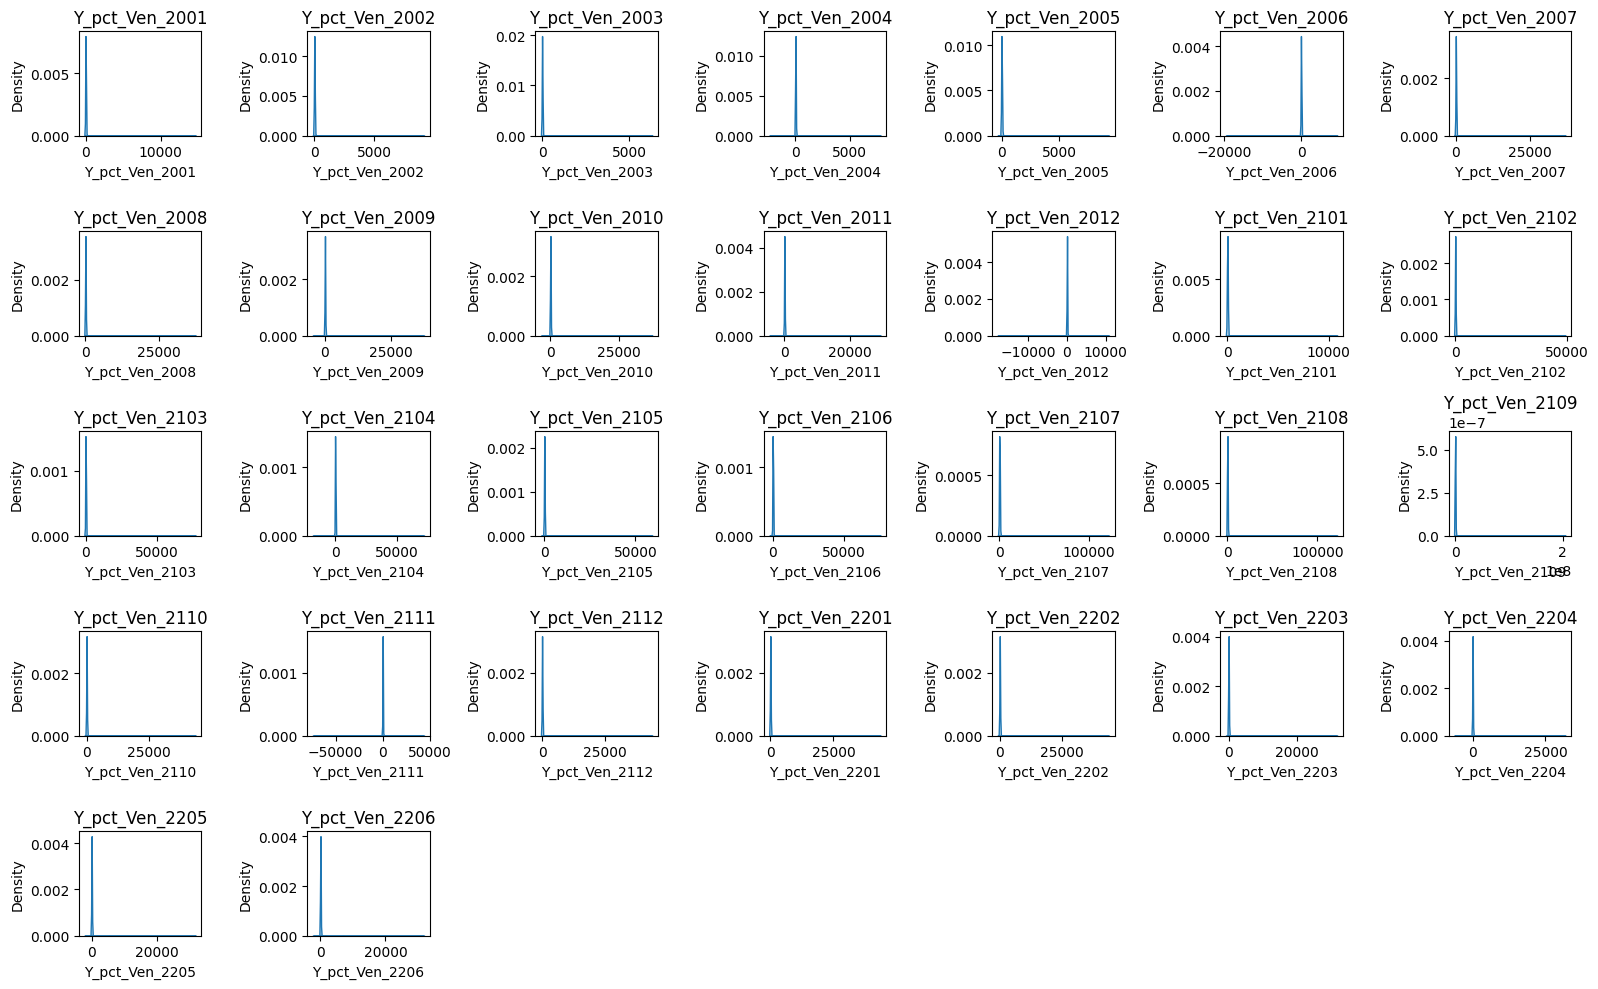

In [45]:
# Configuración del diseño del gráfico
plt.figure(figsize=(16, 10))  # Tamaño del layout

# Itera a través de cada columna y crea un KDE plot
for column in vectores_interes.columns:
    plt.subplot(5, 7, vectores_interes.columns.get_loc(column) + 1)  # 5 filas, 7 columnas
    sns.kdeplot(vectores_interes[column], fill=True)
    plt.title(column)

# Ajusta la disposición y muestra el gráfico
plt.tight_layout()
plt.show()

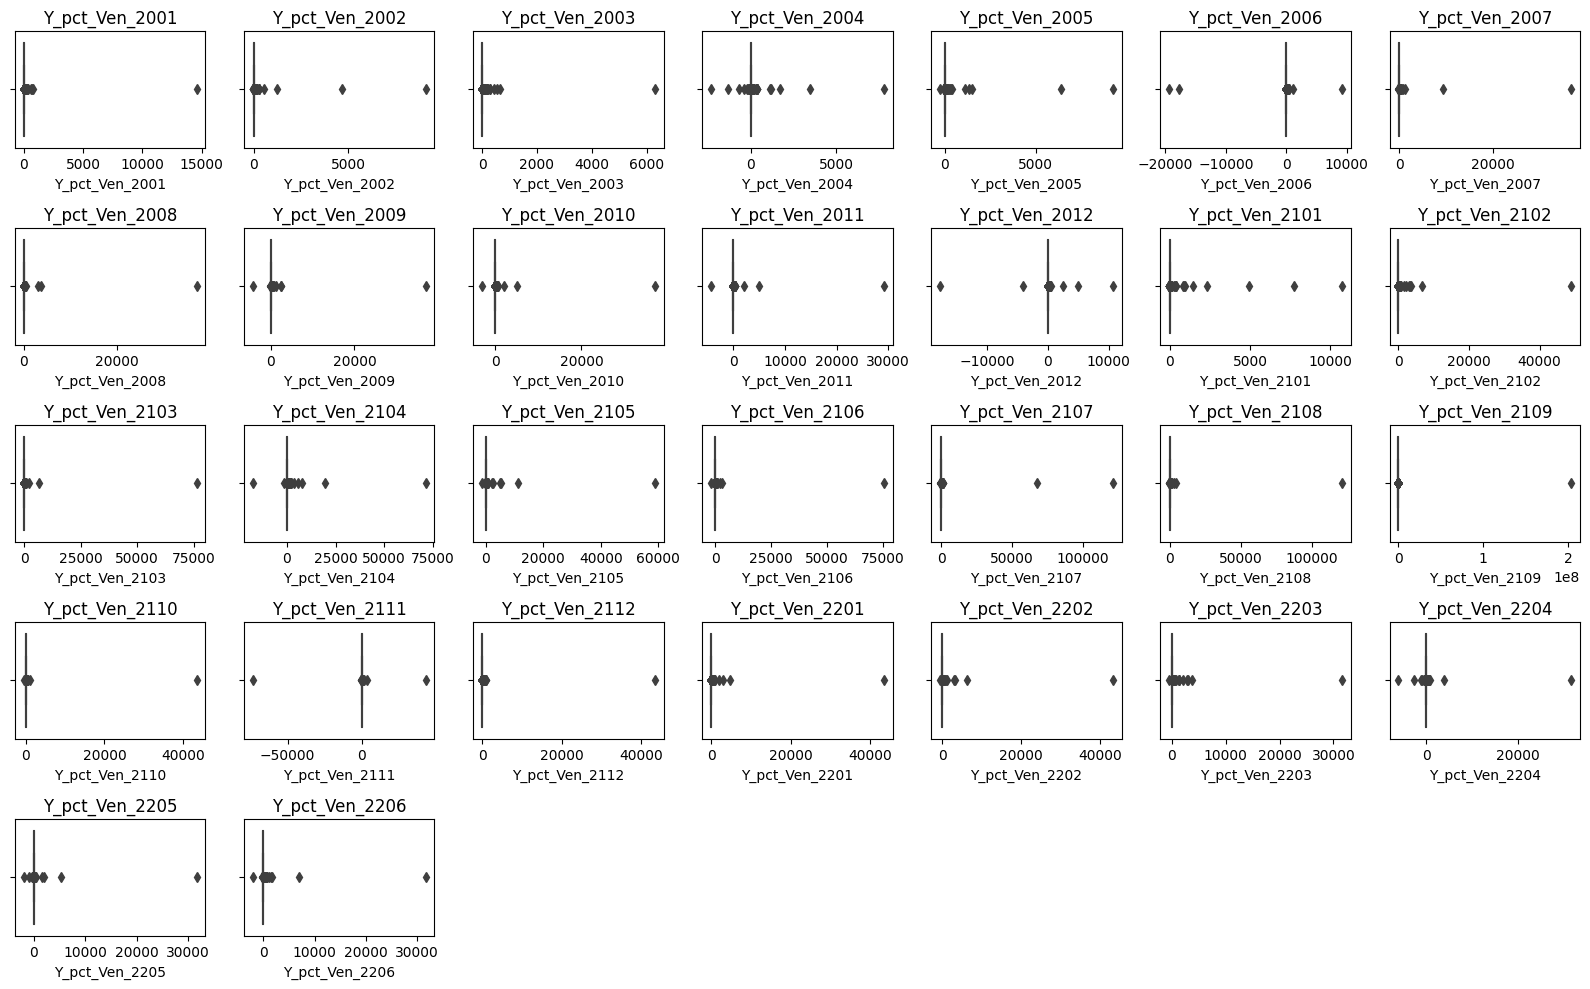

In [47]:
# Configuración del diseño del gráfico
plt.figure(figsize=(16, 10))  # Tamaño del layout

# Itera a través de cada columna y crea un boxplot
for i, column in enumerate(vectores_interes.columns):
    plt.subplot(5, 7, i + 1)  # 5 filas, 7 columnas
    sns.boxplot(x=vectores_interes[column])
    plt.title(column)

# Ajusta la disposición y muestra el gráfico
plt.tight_layout()
plt.show()

---
## Selección del Número de Clusters <span style="color:magenta">**(Paso 2)**</span>

### Elbow method

Para probar, le quito los vacíos.

In [52]:
vectores_interes_sin_vacios = vectores_interes.dropna().copy()
vectores_interes_sin_vacios

,Y_pct_Ven_2001,Y_pct_Ven_2002,Y_pct_Ven_2003,Y_pct_Ven_2004,Y_pct_Ven_2005,Y_pct_Ven_2006,Y_pct_Ven_2007,Y_pct_Ven_2008,Y_pct_Ven_2009,Y_pct_Ven_2010,Y_pct_Ven_2011,Y_pct_Ven_2012,Y_pct_Ven_2101,Y_pct_Ven_2102,Y_pct_Ven_2103,Y_pct_Ven_2104,Y_pct_Ven_2105,Y_pct_Ven_2106,Y_pct_Ven_2107,Y_pct_Ven_2108,Y_pct_Ven_2109,Y_pct_Ven_2110,Y_pct_Ven_2111,Y_pct_Ven_2112,Y_pct_Ven_2201,Y_pct_Ven_2202,Y_pct_Ven_2203,Y_pct_Ven_2204,Y_pct_Ven_2205,Y_pct_Ven_2206
0,-0.980420,-0.965571,-0.965571,-0.987611,-0.987611,-0.943671,36606.764001,37024.978792,37024.978792,37024.978792,29167.514747,10732.811495,10732.811495,2266.832776,2266.832776,2266.832776,2266.832776,2266.832776,-0.938050,-0.938750,-0.997244,-0.997244,-0.919475,-0.450937,-0.819822,-0.147205,0.023844,-0.119376,-0.119376,-0.352698
1,0.032923,0.067118,-0.569663,-0.999617,-0.929885,-0.322981,-0.201898,-0.273524,-0.348675,-0.448290,-0.398790,-0.216869,-0.358698,-0.373762,0.747936,2149.215226,7.797906,-0.072916,-0.195142,0.134928,0.353202,0.299397,0.244381,-0.052702,-0.021221,0.453017,0.027594,0.183219,0.475884,0.351416
2,0.256607,0.174306,-0.298710,-0.971207,-0.548703,-0.125982,0.097048,0.442733,2.131407,2.082447,1.524440,0.615983,0.300691,-0.034593,2.914301,71.848516,2.098552,1.304784,0.223360,0.211571,-0.250917,-0.102872,-0.431158,-0.332711,-0.332390,0.737398,-0.645376,-0.433219,-0.221058,-0.274480
3,-0.090954,-0.366634,-0.118110,-0.068514,-0.156388,-0.206558,-0.085699,-0.127638,0.153705,0.146317,0.285224,0.371626,0.344026,1.025021,0.349786,0.401290,0.238506,0.229865,0.431187,0.427207,0.168828,-0.037599,-0.102040,-0.167593,-0.381054,-0.416867,-0.242169,-0.277885,-0.396566,-0.151606
5,-0.138852,0.689955,-0.521864,2.388099,0.567516,0.642986,3.274487,0.538544,1.452733,-0.159726,-0.165609,-0.561467,-0.079751,0.675037,0.712530,-0.733821,-0.522277,-0.304619,0.081671,1.585892,1.135908,0.604031,0.083224,1.613303,1.361322,-0.497735,0.191964,4.681364,-0.307318,1.664215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4518,0.319850,-0.238400,-0.192796,0.565650,1.133626,1.730680,0.189236,2.275443,0.256407,-0.280546,0.138059,-0.143250,0.203089,0.517108,0.692032,0.379805,-0.388588,-0.332302,0.142803,-0.042017,-0.027875,0.131967,0.404119,0.291373,-0.065622,-0.132337,0.064121,-0.208628,0.034839,0.324905
4520,0.129362,0.130515,-0.345630,-0.804332,-0.372216,0.055952,-0.078660,-0.060945,-0.012336,-0.018337,-0.046040,0.010530,-0.055409,0.020368,0.726036,4.541196,0.238063,-0.106999,0.077217,-0.012692,0.076983,-0.044526,0.079762,0.063366,-0.034933,0.018941,0.064950,0.029696,0.274339,0.223458
4521,-0.590927,-0.423382,-0.450799,-0.585265,-0.689068,-0.643809,-0.537315,-0.418033,-0.214571,-0.491477,0.388262,-0.807880,0.069491,-0.485770,-0.241089,0.550625,0.637116,0.177926,0.396695,-0.126780,-0.518709,1.596319,0.049990,29.886271,-0.156044,0.185376,-0.232027,-0.376248,-0.453461,0.081264
4522,0.022664,0.128599,0.043768,-0.287101,-0.295110,-0.088874,-0.098262,0.412614,0.060567,-0.298479,-0.341842,-0.274791,-0.103288,-0.189465,0.197472,-0.206933,0.465966,0.357232,-0.013343,-0.201053,0.634039,-0.221164,0.541491,0.368499,-0.371308,0.167410,-0.785563,-0.337461,-0.771441,-0.760784


Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

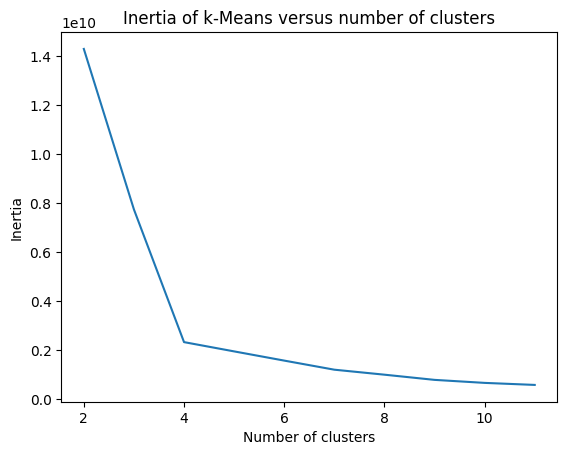

In [53]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i, n_init=10).fit(vectores_interes_sin_vacios).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

### Coeficiente Silhouette

---
## Aplicación de Modelos de Clustering <span style="color:magenta">**(Paso 3)**</span>

### K-means

In [57]:
km = KMeans(n_clusters=4, n_init=10) # El parámetro n_init igual a 10 me lo pide para no tirar error. Ver luego qué implica.
km.fit(vectores_interes_sin_vacios)
clusters = km.labels_

In [58]:
vectores_clusters = vectores_interes_sin_vacios.copy()
vectores_clusters['kmeans_4'] = km.labels_
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')
vectores_clusters.head(4)

Kmeans encontró:  4 clusters, nosotros forzamos la cantidad


,Y_pct_Ven_2001,Y_pct_Ven_2002,Y_pct_Ven_2003,Y_pct_Ven_2004,Y_pct_Ven_2005,Y_pct_Ven_2006,Y_pct_Ven_2007,Y_pct_Ven_2008,Y_pct_Ven_2009,Y_pct_Ven_2010,Y_pct_Ven_2011,Y_pct_Ven_2012,Y_pct_Ven_2101,Y_pct_Ven_2102,Y_pct_Ven_2103,Y_pct_Ven_2104,Y_pct_Ven_2105,Y_pct_Ven_2106,Y_pct_Ven_2107,Y_pct_Ven_2108,Y_pct_Ven_2109,Y_pct_Ven_2110,Y_pct_Ven_2111,Y_pct_Ven_2112,Y_pct_Ven_2201,Y_pct_Ven_2202,Y_pct_Ven_2203,Y_pct_Ven_2204,Y_pct_Ven_2205,Y_pct_Ven_2206,kmeans_4
0,-0.980420,-0.965571,-0.965571,-0.987611,-0.987611,-0.943671,36606.764001,37024.978792,37024.978792,37024.978792,29167.514747,10732.811495,10732.811495,2266.832776,2266.832776,2266.832776,2266.832776,2266.832776,-0.938050,-0.938750,-0.997244,-0.997244,-0.919475,-0.450937,-0.819822,-0.147205,0.023844,-0.119376,-0.119376,-0.352698,2
1,0.032923,0.067118,-0.569663,-0.999617,-0.929885,-0.322981,-0.201898,-0.273524,-0.348675,-0.448290,-0.398790,-0.216869,-0.358698,-0.373762,0.747936,2149.215226,7.797906,-0.072916,-0.195142,0.134928,0.353202,0.299397,0.244381,-0.052702,-0.021221,0.453017,0.027594,0.183219,0.475884,0.351416,0
2,0.256607,0.174306,-0.298710,-0.971207,-0.548703,-0.125982,0.097048,0.442733,2.131407,2.082447,1.524440,0.615983,0.300691,-0.034593,2.914301,71.848516,2.098552,1.304784,0.223360,0.211571,-0.250917,-0.102872,-0.431158,-0.332711,-0.332390,0.737398,-0.645376,-0.433219,-0.221058,-0.274480,0
3,-0.090954,-0.366634,-0.118110,-0.068514,-0.156388,-0.206558,-0.085699,-0.127638,0.153705,0.146317,0.285224,0.371626,0.344026,1.025021,0.349786,0.401290,0.238506,0.229865,0.431187,0.427207,0.168828,-0.037599,-0.102040,-0.167593,-0.381054,-0.416867,-0.242169,-0.277885,-0.396566,-0.151606,0


In [62]:
vectores_clusters['kmeans_4'].value_counts()

kmeans_4
0    3627
2       1
1       1
3       1
Name: count, dtype: int64

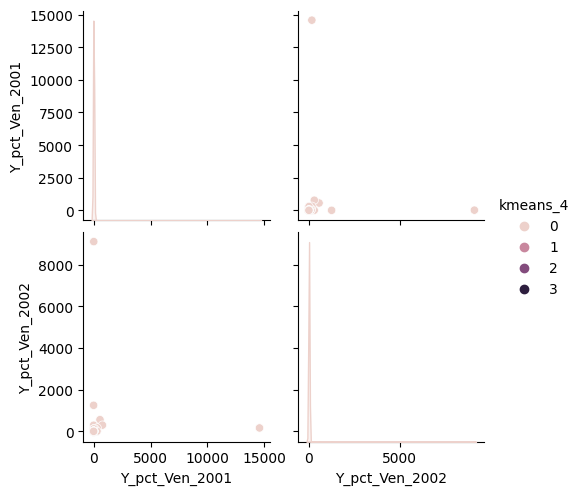

In [61]:
selected_columns = [Y_Ven[0], Y_Ven[1], 'kmeans_4']
sns.pairplot(vectores_clusters[selected_columns], hue='kmeans_4')

Probando para un solo rubro..

In [65]:
vectores_interes = vectores[basics + Y_Ven]
vectores_gondola = vectores_interes[vectores_interes['Subrubro'] == 'Gondola'].copy()
vectores_gondola = vectores_gondola.dropna().copy()
vectores_gondola

,Modelo,Subrubro,Y_pct_Ven_2001,Y_pct_Ven_2002,Y_pct_Ven_2003,Y_pct_Ven_2004,Y_pct_Ven_2005,Y_pct_Ven_2006,Y_pct_Ven_2007,Y_pct_Ven_2008,Y_pct_Ven_2009,Y_pct_Ven_2010,Y_pct_Ven_2011,Y_pct_Ven_2012,Y_pct_Ven_2101,Y_pct_Ven_2102,Y_pct_Ven_2103,Y_pct_Ven_2104,Y_pct_Ven_2105,Y_pct_Ven_2106,Y_pct_Ven_2107,Y_pct_Ven_2108,Y_pct_Ven_2109,Y_pct_Ven_2110,Y_pct_Ven_2111,Y_pct_Ven_2112,Y_pct_Ven_2201,Y_pct_Ven_2202,Y_pct_Ven_2203,Y_pct_Ven_2204,Y_pct_Ven_2205,Y_pct_Ven_2206
3,0,Gondola,-0.090954,-0.366634,-0.118110,-0.068514,-0.156388,-0.206558,-0.085699,-0.127638,0.153705,0.146317,0.285224,0.371626,0.344026,1.025021,0.349786,0.401290,0.238506,0.229865,0.431187,0.427207,0.168828,-0.037599,-0.102040,-0.167593,-0.381054,-0.416867,-0.242169,-0.277885,-0.396566,-0.151606
9,0,Gondola,0.071386,-0.051197,-0.083747,0.010715,-0.068835,0.068352,0.126651,0.278542,0.021054,0.093775,-0.202593,0.155079,-0.221694,0.094594,0.010343,-0.005323,0.064254,0.070439,-0.098021,-0.068563,0.131345,-0.060587,0.431169,0.226544,0.142378,-0.030746,0.182961,0.202960,0.167332,0.048929
11,0,Gondola,-0.221378,0.094467,-0.095069,0.563833,-0.251842,0.478978,-0.001720,0.412783,0.695157,-0.253389,0.147017,0.673522,0.786676,1.136970,0.921293,0.310494,0.011793,0.498297,0.412726,0.452163,0.260517,1.110026,0.745267,-0.130876,-0.445690,-0.493564,-0.122608,0.439668,0.822868,0.106082
17,0,Gondola,0.500167,0.503345,0.547481,0.344422,0.355886,0.408074,0.273444,0.245982,0.278328,0.146178,0.152442,0.093781,0.039047,-0.016032,-0.089270,0.003215,0.058502,-0.026805,0.038943,-0.025714,-0.005894,0.106417,0.001671,0.011519,-0.039148,-0.081689,-0.035290,-0.045252,-0.048187,0.043702
18,1,Gondola,-0.126088,-0.132331,-0.104575,0.009693,-0.192917,-0.118210,-0.133327,-0.000331,0.128586,0.123829,0.052264,0.049823,-0.278268,0.116488,-0.089833,-0.145393,-0.095028,-0.096365,-0.092112,-0.106952,-0.168458,-0.187445,-0.071311,-0.088320,0.207496,0.050226,-0.049518,-0.148213,-0.020871,-0.079855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4478,0,Gondola,0.337230,0.431850,0.177272,-0.053534,-0.183849,0.123884,0.100281,-0.215428,-0.240816,-0.183394,-0.216869,-0.034593,-0.155522,-0.150570,-0.145945,-0.144845,-0.129327,-0.100512,-0.084778,0.025119,0.094559,-0.010832,0.122440,-0.069846,-0.256226,-0.102322,0.020811,0.232436,0.240241,0.203576
4479,0,Gondola,-0.519978,0.021659,-0.439678,-0.306915,1.053718,-0.382644,4.821066,5.425724,4.412112,2.685887,3.895425,1.580137,20.580532,2.528574,6.499132,1.121660,3.079404,10.955886,-0.039702,-0.253440,-0.116115,-0.096522,-0.108593,-0.022876,-0.078927,-0.004723,-0.287575,0.074358,-0.564454,-0.175172
4492,0,Gondola,3.399077,3.796687,2.552012,0.922400,0.973348,-0.430773,-0.432966,-0.436876,-0.400274,-0.437974,-0.337106,-0.386253,-0.443707,-0.474442,-0.145576,0.662607,2.818025,0.369379,0.562938,0.484100,0.591134,0.064651,0.218940,0.307281,-0.719947,0.282367,0.288983,0.207571,-0.545627,0.175747
4503,0,Gondola,-0.201117,0.306558,-0.041610,0.148665,-0.180605,0.948029,0.295568,-0.470979,10.410532,1.244395,1.769132,7.512976,0.021224,-0.058432,0.947521,0.723352,0.446385,-0.222657,-0.511854,0.325538,-0.212174,0.097009,0.109651,1.290904,0.324133,0.543724,-0.051137,-0.484126,0.339357,-0.318618


In [67]:
vectores_gondola = vectores_gondola[Y_Ven].copy()

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

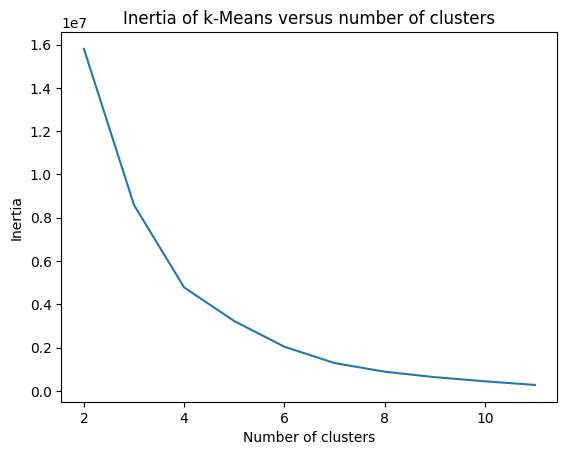

In [68]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i, n_init=10).fit(vectores_gondola).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [69]:
km = KMeans(n_clusters=4, n_init=10) # El parámetro n_init igual a 10 me lo pide para no tirar error. Ver luego qué implica.
km.fit(vectores_gondola)
clusters = km.labels_

In [70]:
vectores_clusters = vectores_gondola.copy()
vectores_clusters['kmeans_4'] = km.labels_
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')
vectores_clusters.head(4)

Kmeans encontró:  4 clusters, nosotros forzamos la cantidad


,Y_pct_Ven_2001,Y_pct_Ven_2002,Y_pct_Ven_2003,Y_pct_Ven_2004,Y_pct_Ven_2005,Y_pct_Ven_2006,Y_pct_Ven_2007,Y_pct_Ven_2008,Y_pct_Ven_2009,Y_pct_Ven_2010,Y_pct_Ven_2011,Y_pct_Ven_2012,Y_pct_Ven_2101,Y_pct_Ven_2102,Y_pct_Ven_2103,Y_pct_Ven_2104,Y_pct_Ven_2105,Y_pct_Ven_2106,Y_pct_Ven_2107,Y_pct_Ven_2108,Y_pct_Ven_2109,Y_pct_Ven_2110,Y_pct_Ven_2111,Y_pct_Ven_2112,Y_pct_Ven_2201,Y_pct_Ven_2202,Y_pct_Ven_2203,Y_pct_Ven_2204,Y_pct_Ven_2205,Y_pct_Ven_2206,kmeans_4
3,-0.090954,-0.366634,-0.118110,-0.068514,-0.156388,-0.206558,-0.085699,-0.127638,0.153705,0.146317,0.285224,0.371626,0.344026,1.025021,0.349786,0.401290,0.238506,0.229865,0.431187,0.427207,0.168828,-0.037599,-0.102040,-0.167593,-0.381054,-0.416867,-0.242169,-0.277885,-0.396566,-0.151606,0
9,0.071386,-0.051197,-0.083747,0.010715,-0.068835,0.068352,0.126651,0.278542,0.021054,0.093775,-0.202593,0.155079,-0.221694,0.094594,0.010343,-0.005323,0.064254,0.070439,-0.098021,-0.068563,0.131345,-0.060587,0.431169,0.226544,0.142378,-0.030746,0.182961,0.202960,0.167332,0.048929,0
11,-0.221378,0.094467,-0.095069,0.563833,-0.251842,0.478978,-0.001720,0.412783,0.695157,-0.253389,0.147017,0.673522,0.786676,1.136970,0.921293,0.310494,0.011793,0.498297,0.412726,0.452163,0.260517,1.110026,0.745267,-0.130876,-0.445690,-0.493564,-0.122608,0.439668,0.822868,0.106082,0
17,0.500167,0.503345,0.547481,0.344422,0.355886,0.408074,0.273444,0.245982,0.278328,0.146178,0.152442,0.093781,0.039047,-0.016032,-0.089270,0.003215,0.058502,-0.026805,0.038943,-0.025714,-0.005894,0.106417,0.001671,0.011519,-0.039148,-0.081689,-0.035290,-0.045252,-0.048187,0.043702,0


In [71]:
vectores_clusters['kmeans_4'].value_counts()

kmeans_4
0    465
3      1
2      1
1      1
Name: count, dtype: int64

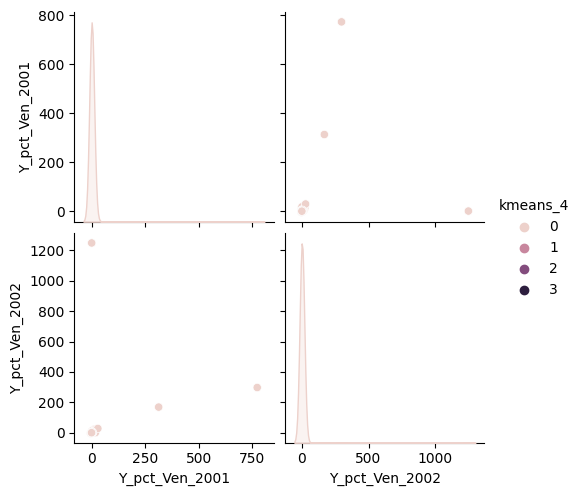

In [72]:
selected_columns = [Y_Ven[0], Y_Ven[1], 'kmeans_4']
sns.pairplot(vectores_clusters[selected_columns], hue='kmeans_4')

### Otros algoritmos de clustering

---
## Visualización de Resultados <span style="color:magenta">**(Paso 4)**</span>

---
## Interpretación y Evaluación <span style="color:magenta">**(Paso 5)**</span>

---
## Confianza en los Resultados <span style="color:magenta">**(Paso 6)**</span>

---
## Preguntas finales <span style="color:magenta">**(Paso 7)**</span>